<a href="https://colab.research.google.com/github/mahsoutoura/Deloitte-Machine-Learning-Challenge-Predict-Loan-Defaulters/blob/main/Copy_of_Challenge_Deloitte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [ ]:
!pip install catboost
!pip install xgboost
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

import optuna #for hyperparameters tuning
from optuna.integration import LightGBMPruningCallback

import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, roc_curve, roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import StackingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cat
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import RandomOverSampler
from collections import Counter 

import random
random.seed(123)

# **Reading the data** 

In [3]:
train = pd.read_csv('train.csv')
train.head(3)

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0


In [4]:
test = pd.read_csv('test.csv')
test.head(3)

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,56492997,17120,10365,16025.08269,59,BAT2575549,12.163926,A,D1,RENT,76468.82190,Source Verified,n,Home improvement,16.749219,1,0,12,1,3576,67.278287,5,f,4469.449851,0.088031,8.425776,0.731797,0,INDIVIDUAL,135,0,24,475442,4364,NaN
1,22540813,7133,11650,12615.79560,59,BAT2833642,6.564296,B,E3,MORTGAGE,38079.01344,Source Verified,n,Credit card refinancing,18.157975,0,0,11,0,1932,71.313157,21,w,993.907530,0.041237,6.157008,0.992918,0,INDIVIDUAL,56,0,1,72412,2573,NaN
2,9862181,25291,25825,11621.28083,59,BAT1761981,14.729900,A,C3,MORTGAGE,51275.93268,Source Verified,n,Debt consolidation,15.190011,0,0,22,0,598,50.883065,23,f,729.113379,0.021745,5.705077,0.281580,0,INDIVIDUAL,3,0,26,284825,19676,NaN


In [5]:
ss = pd.read_csv('submission.csv')
ss.head(3)

,Loan Status
0,0
1,0
2,0


# **Combine train and test**

In [6]:
#Combine train and test set
ntrain = train.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (96376, 35)


In [7]:
#Removing duplicate rows if any
print('Shape of the training set before deleting duplicate values:', all_data.shape)

all_data = all_data.drop_duplicates()
print('Shape After deleting duplicate values:', all_data.shape)
all_data.drop(['ID'], 1, inplace = True)

Shape of the training set before deleting duplicate values: (96376, 35)
Shape After deleting duplicate values: (96376, 35)


In [8]:
all_data.head(3)

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0.0
1,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0.0
2,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0.0


# **Data Exploration** 

In [9]:
#the names of the columns 'Home Ownership': and 'Employment Duration' were reversed
all_data.rename(columns={'Home Ownership': 'Employment Duration', "Employment Duration":"Home Ownership"}, inplace=True)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96376 entries, 0 to 96375
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan Amount                   96376 non-null  int64  
 1   Funded Amount                 96376 non-null  int64  
 2   Funded Amount Investor        96376 non-null  float64
 3   Term                          96376 non-null  int64  
 4   Batch Enrolled                96376 non-null  object 
 5   Interest Rate                 96376 non-null  float64
 6   Grade                         96376 non-null  object 
 7   Sub Grade                     96376 non-null  object 
 8   Home Ownership                96376 non-null  object 
 9   Employment Duration           96376 non-null  float64
 10  Verification Status           96376 non-null  object 
 11  Payment Plan                  96376 non-null  object 
 12  Loan Title                    96376 non-null  object 
 13  D

#### **Let's visualize categorical features**

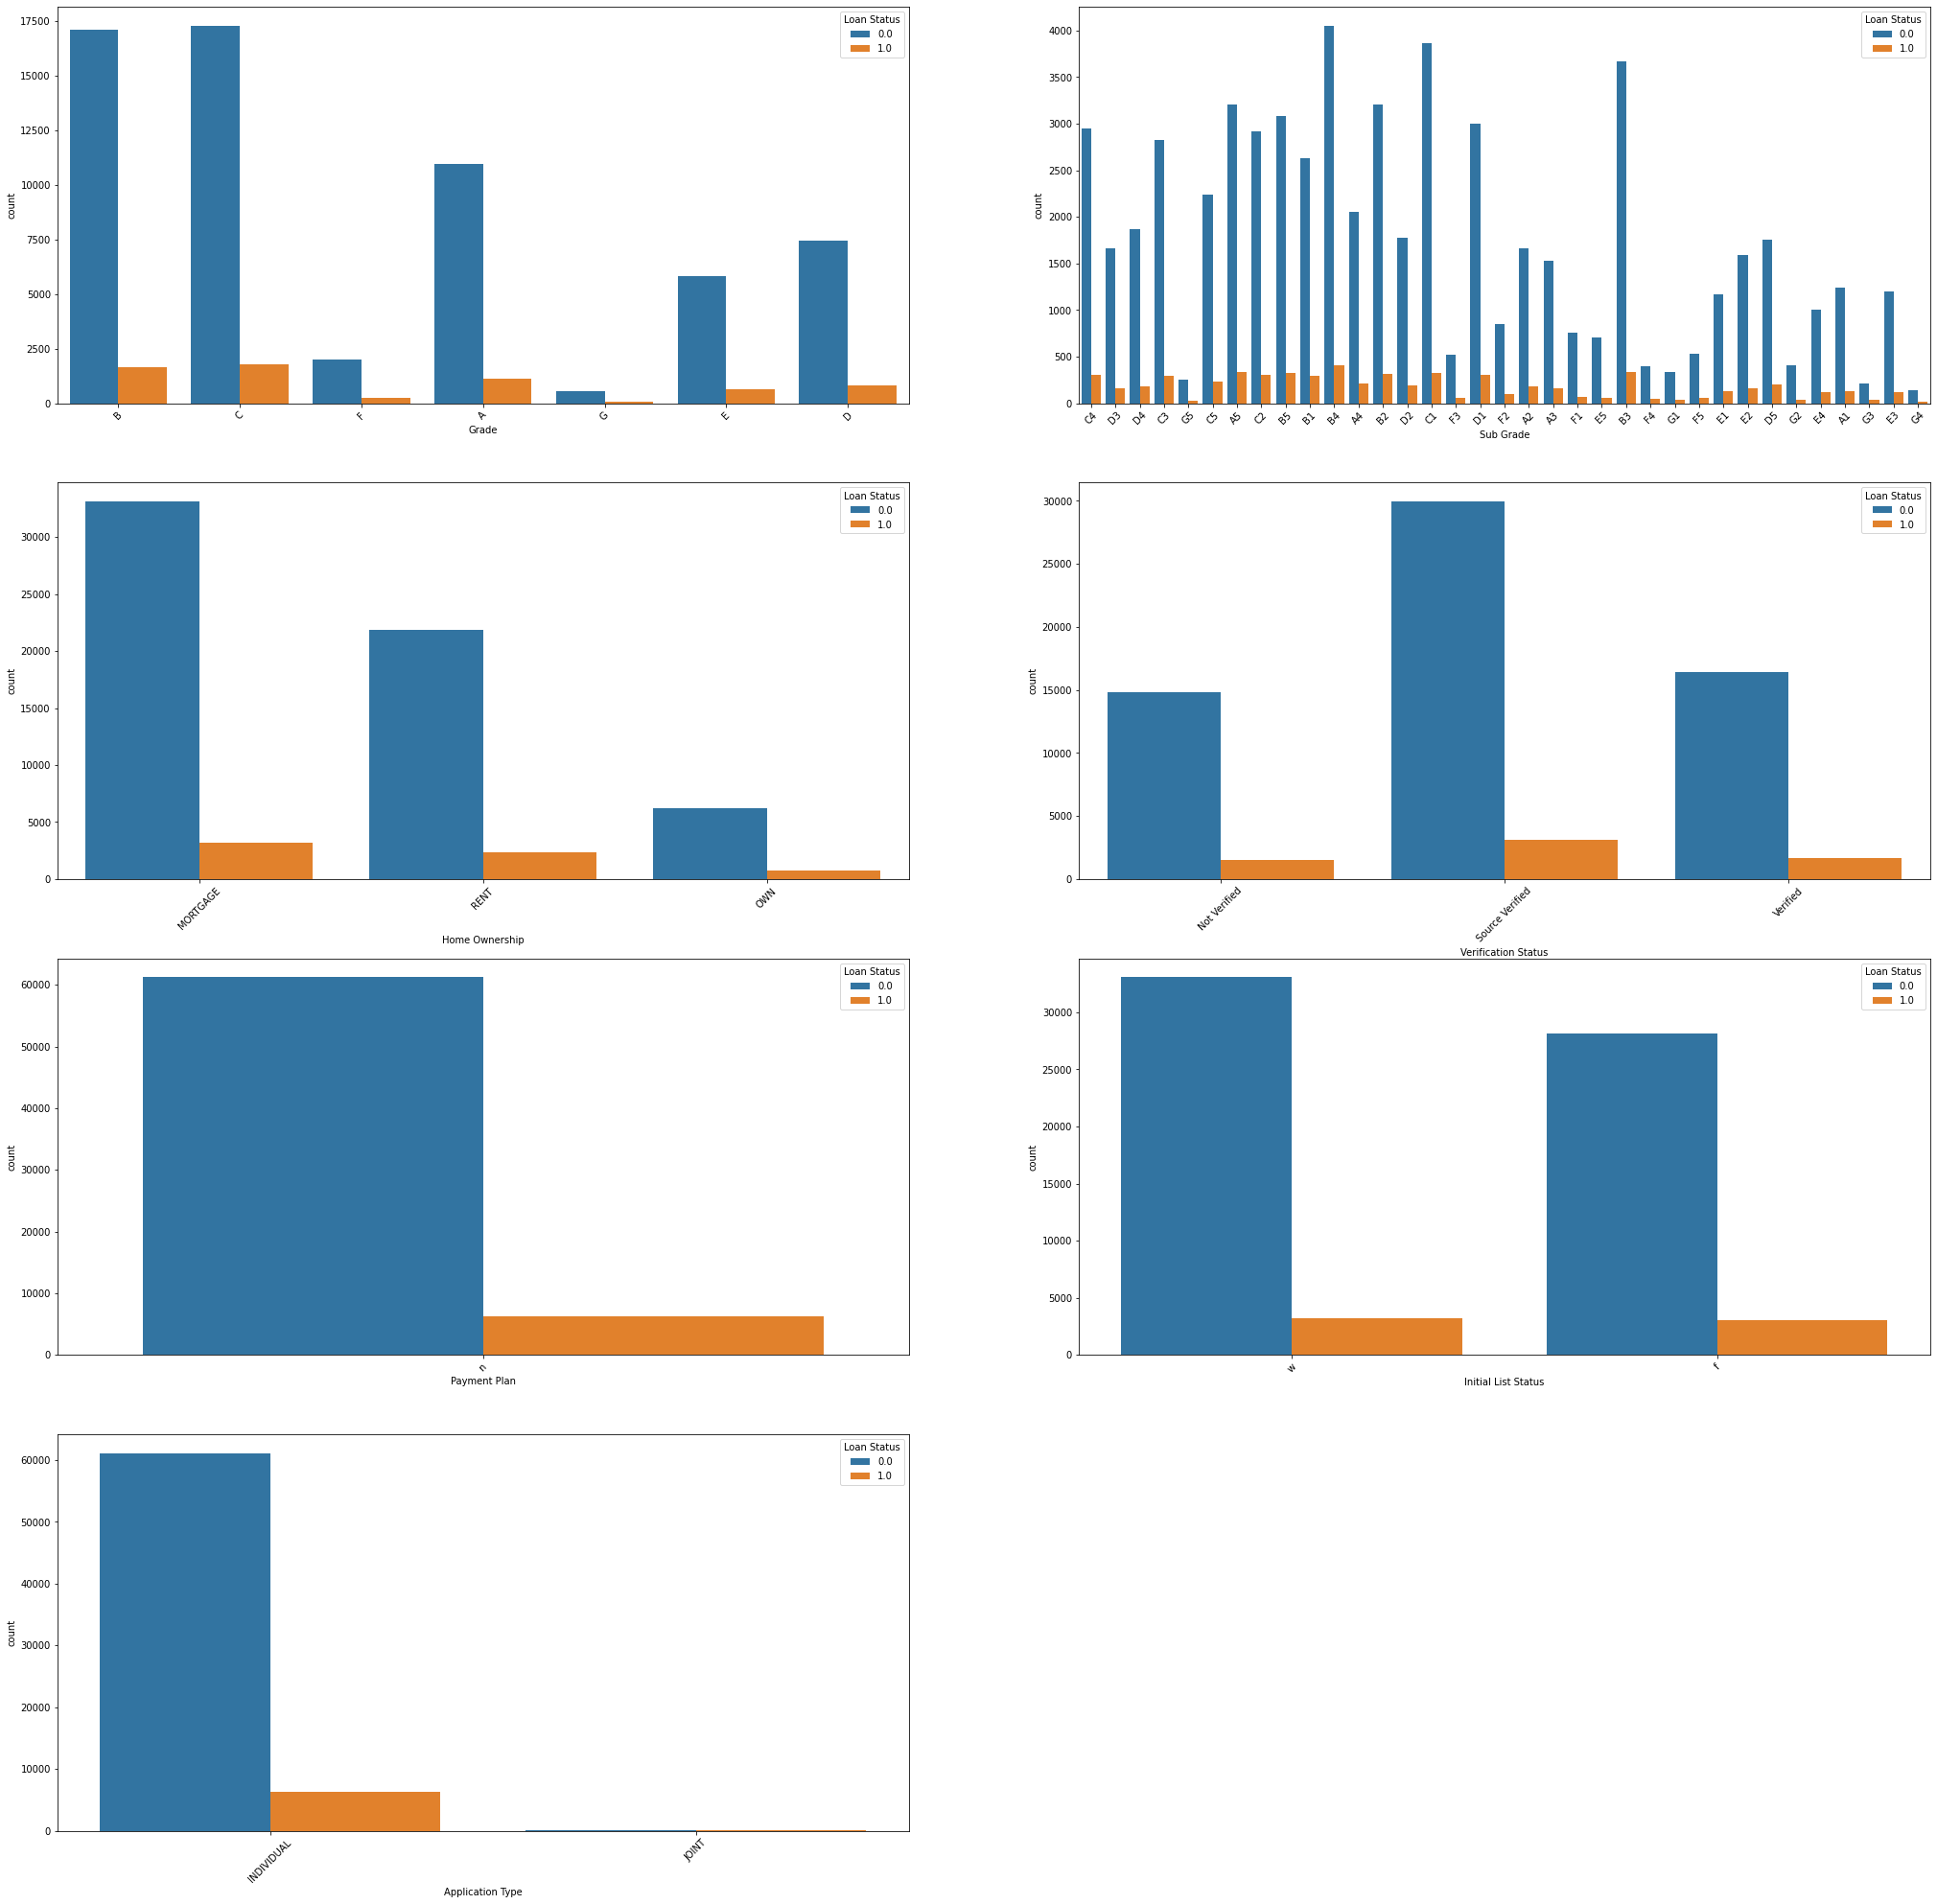

In [ ]:
#catCols = all_data.select_dtypes(include="object").columns
catCols=['Grade', 'Sub Grade', 'Home Ownership',
       'Verification Status', 'Payment Plan',
       'Initial List Status', 'Application Type']
plt.figure(figsize=(35,35))
for i in enumerate(catCols):
  plt.subplot(4, 2, i[0]+1)
  sns.countplot(i[1], hue="Loan Status", data=all_data)
  plt.xticks(rotation=45)


### **Check summary of numerical fields**

In [14]:
numCols = all_data.select_dtypes(include=['int64', 'float64'])
numCols = numCols.drop('Loan Status', axis=1)
numCols.describe().T

,count,mean,std,min,25%,50%,75%,max
Loan Amount,96376.0,16715.439259,8367.617027,1000.000000,9953.000000,15947.000000,21987.250000,3.500000e+04
Funded Amount,96376.0,15725.392401,8175.017327,1000.000000,9238.000000,13076.000000,21724.000000,3.500000e+04
Funded Amount Investor,96376.0,14657.720784,6922.046851,1000.000000,9800.036208,12826.006220,18382.681483,3.500000e+04
Term,96376.0,57.084585,5.896938,36.000000,58.000000,59.000000,59.000000,6.000000e+01
Interest Rate,96376.0,11.948654,3.780666,5.320000,9.326588,11.471511,14.330000,2.731000e+01
Employment Duration,96376.0,80374.176313,45090.364452,14573.537170,51459.374773,69217.985460,94650.134950,4.069449e+05
Debit to Income,96376.0,22.957246,8.530055,0.675299,16.424179,22.296056,29.678280,3.962998e+01
Delinquency - two years,96376.0,0.328609,0.806324,0.000000,0.000000,0.000000,0.000000,9.000000e+00
Inquires - six months,96376.0,0.185098,0.540999,0.000000,0.000000,0.000000,0.000000,5.000000e+00
Open Account,96376.0,14.085623,6.198315,2.000000,10.000000,12.000000,16.000000,3.700000e+01


#### **Let's visualize numerical features**

In [15]:
numColumns = []
for col in numCols:
  numColumns.append(col)


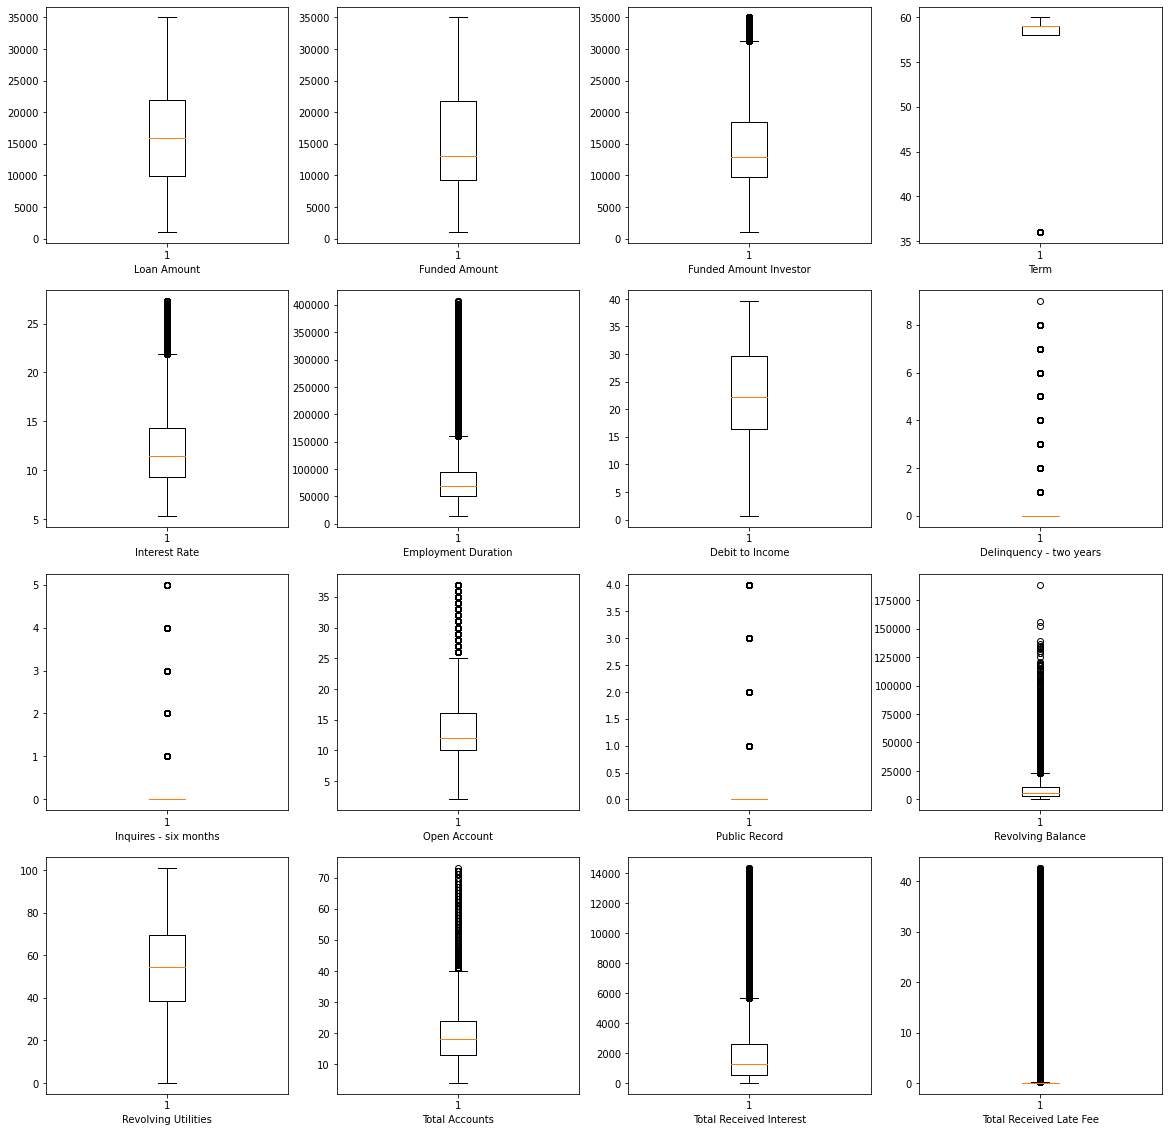

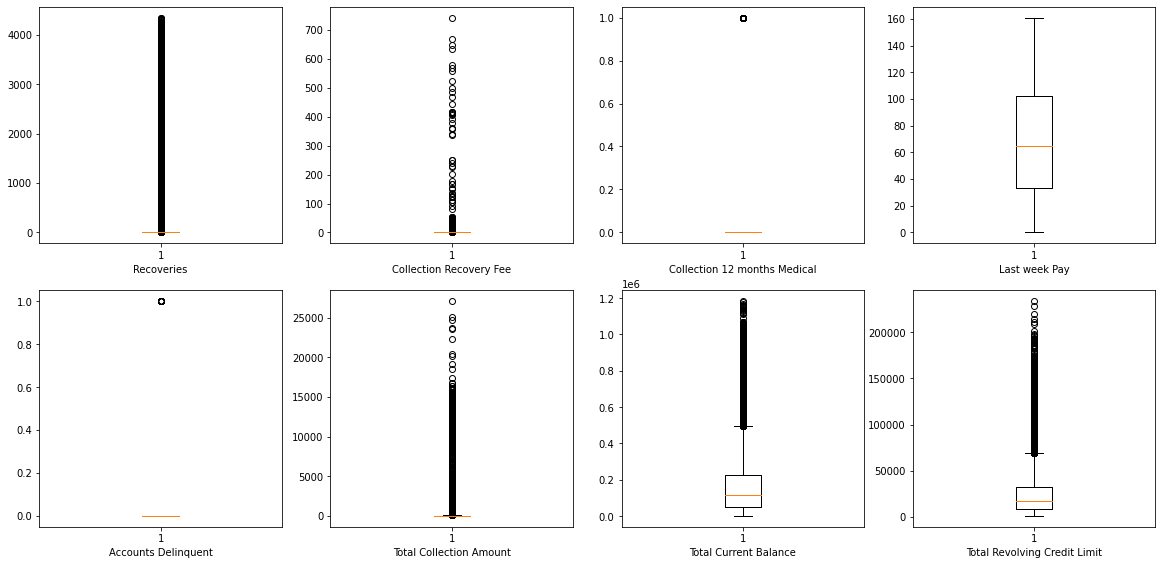

In [ ]:
plt.figure(figsize=(20,20))
for i in enumerate(numColumns[0:16]):
  plt.subplot(4, 4, i[0]+1)
  plt.boxplot(all_data[i[1]])
  plt.xlabel(i[1])

plt.figure(figsize=(20,20))
for i in enumerate(numColumns[16:24]):
  plt.subplot(4, 4, i[0]+1)
  plt.boxplot(all_data[i[1]])
  plt.xlabel(i[1])

**Some features like 'Employment Duration' and 'Total Received Interest' contain extreme outliers => outliers treatment during pre-processing**

Text(0, 0.5, 'Loan Status')

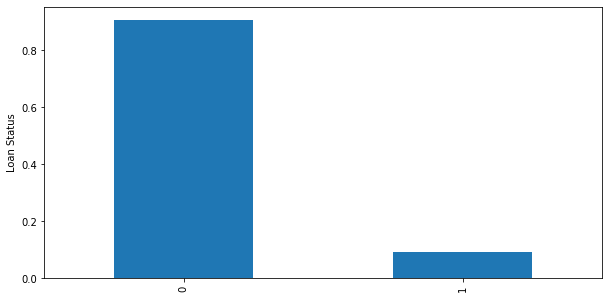

In [17]:
plt.figure(figsize=(10,5))
train['Loan Status'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('Loan Status')

In [ ]:
train['Loan Status'].value_counts()

0    61222
1     6241
Name: Loan Status, dtype: int64

**90% of the clients in the dataset payed their loans on time whereas 10% did not.**

# **Preprocessing and Feature Engineering**

#### **Outliers**

In [18]:
outliers = ['Funded Amount Investor', 'Interest Rate', 'Employment Duration', 'Revolving Balance', 'Total Accounts',
            'Total Received Interest', 'Total Current Balance', 'Total Revolving Credit Limit']

In [20]:
#replacing outliers with null values
for outlier in outliers:
  B = plt.boxplot(all_data[outlier])
  max_whisker = [item.get_ydata()[1] for item in B['whiskers']][1]
  all_data[outlier] = np.where(all_data[outlier]>max_whisker,  np.NaN, all_data[outlier])
plt.close()

#### **Missing values** 

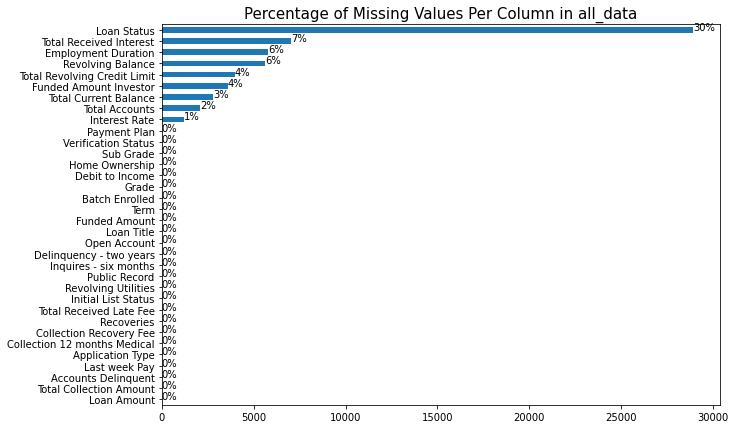

In [22]:
# Check if there any missing values in all_data 
ax = all_data.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in all_data', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/all_data.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y)) 

In [23]:
#Replacing missing values with the median
all_data['Total Received Interest'].fillna((all_data['Total Received Interest'].median()), inplace=True)
all_data['Employment Duration'].fillna((all_data['Employment Duration'].median()), inplace=True)
all_data['Revolving Balance'].fillna((all_data['Revolving Balance'].median()), inplace=True)
all_data['Total Revolving Credit Limit'].fillna((all_data['Total Revolving Credit Limit'].median()), inplace=True)
all_data['Funded Amount Investor'].fillna((all_data['Funded Amount Investor'].median()), inplace=True)
all_data['Total Current Balance'].fillna((all_data['Total Current Balance'].median()), inplace=True)
all_data['Total Accounts'].fillna((all_data['Total Accounts'].median()), inplace=True)
all_data['Interest Rate'].fillna((all_data['Interest Rate'].median()), inplace=True)

In [24]:
all_data.isna().sum()

Loan Amount                         0
Funded Amount                       0
Funded Amount Investor              0
Term                                0
Batch Enrolled                      0
Interest Rate                       0
Grade                               0
Sub Grade                           0
Home Ownership                      0
Employment Duration                 0
Verification Status                 0
Payment Plan                        0
Loan Title                          0
Debit to Income                     0
Delinquency - two years             0
Inquires - six months               0
Open Account                        0
Public Record                       0
Revolving Balance                   0
Revolving Utilities                 0
Total Accounts                      0
Initial List Status                 0
Total Received Interest             0
Total Received Late Fee             0
Recoveries                          0
Collection Recovery Fee             0
Collection 1

In [25]:
numCols.describe().T

,count,mean,std,min,25%,50%,75%,max
Loan Amount,96376.0,16715.439259,8367.617027,1000.000000,9953.000000,15947.000000,21987.250000,3.500000e+04
Funded Amount,96376.0,15725.392401,8175.017327,1000.000000,9238.000000,13076.000000,21724.000000,3.500000e+04
Funded Amount Investor,96376.0,14657.720784,6922.046851,1000.000000,9800.036208,12826.006220,18382.681483,3.500000e+04
Term,96376.0,57.084585,5.896938,36.000000,58.000000,59.000000,59.000000,6.000000e+01
Interest Rate,96376.0,11.948654,3.780666,5.320000,9.326588,11.471511,14.330000,2.731000e+01
Employment Duration,96376.0,80374.176313,45090.364452,14573.537170,51459.374773,69217.985460,94650.134950,4.069449e+05
Debit to Income,96376.0,22.957246,8.530055,0.675299,16.424179,22.296056,29.678280,3.962998e+01
Delinquency - two years,96376.0,0.328609,0.806324,0.000000,0.000000,0.000000,0.000000,9.000000e+00
Inquires - six months,96376.0,0.185098,0.540999,0.000000,0.000000,0.000000,0.000000,5.000000e+00
Open Account,96376.0,14.085623,6.198315,2.000000,10.000000,12.000000,16.000000,3.700000e+01


#### **Creating new features**

In [ ]:
all_data[numColumns + ['Home Ownership']]

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Employment Duration,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Home Ownership
0,10000,32236,12329.36286,59,11.135007,176346.62670,16.284758,1,0,13,0,24246,74.932551,7,2929.646315,0.102055,2.498291,0.793724,0,49,0,31,311301,6619,MORTGAGE
1,3609,11940,12191.99692,59,12.237563,39833.92100,15.412409,0,0,12,0,812,78.297186,13,772.769385,0.036181,2.377215,0.974821,0,109,0,53,182610,20885,RENT
2,28276,9311,21603.22455,59,12.545884,91506.69105,28.137619,0,0,14,0,1843,2.073040,20,863.324396,18.778660,4.316277,1.020075,0,66,0,34,89801,26155,MORTGAGE
3,11170,6954,17877.15585,59,16.731201,108286.57590,18.043730,1,0,7,0,13819,67.467951,12,288.173196,0.044131,0.107020,0.749971,0,39,0,40,9189,60214,MORTGAGE
4,16890,13226,13539.92667,59,15.008300,44234.82545,17.209886,1,3,13,1,1544,85.250761,22,129.239553,19.306646,1294.818751,0.368953,0,18,0,430,126029,22579,MORTGAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96371,35000,35000,35000.00000,60,16.240000,360000.00000,7.310000,0,0,8,1,83274,72.200000,16,10116.330000,0.000000,0.000000,0.000000,0,109,0,0,883984,114000,MORTGAGE
96372,25000,25000,25000.00000,60,14.980000,105000.00000,10.220000,0,1,10,0,26356,50.900000,26,6493.950000,0.000000,0.000000,0.000000,0,104,0,0,513925,51800,MORTGAGE
96373,30000,30000,29950.00000,60,18.240000,74100.00000,27.300000,0,0,19,0,31303,47.700000,45,7785.190000,0.000000,0.000000,0.000000,1,83,0,0,296294,65600,MORTGAGE
96374,25000,25000,24950.00000,60,15.610000,130000.00000,27.290000,2,0,12,0,25470,83.800000,34,5513.520000,0.000000,0.000000,0.000000,0,83,0,0,428723,30400,MORTGAGE


In [26]:
Home_Ownership = all_data[numColumns + ['Home Ownership']].groupby('Home Ownership').mean()
for i in Home_Ownership.columns:
    if i != 'Home Ownership':
        Home_Ownership[i+' mean_Home_Ownership'] = Home_Ownership[i]
        Home_Ownership.drop(i, 1, inplace = True)
all_data = pd.merge(all_data, Home_Ownership, on='Home Ownership', how = 'left')

In [27]:
grade_ = all_data[numColumns + ['Grade']].groupby('Grade').mean()
for i in grade_.columns:
    if i != 'Grade':
        grade_[i+' mean_Grade'] = grade_[i]
        grade_.drop(i, 1, inplace = True)
all_data = pd.merge(all_data, grade_, on='Grade', how = 'left')

In [28]:
verif_status = all_data[numColumns + ['Verification Status']].groupby('Verification Status').mean()
for i in verif_status.columns:
    if i != 'Verification Status':
        verif_status[i+' mean_Verification_Status'] = verif_status[i]
        verif_status.drop(i, 1, inplace = True)
all_data = pd.merge(all_data, verif_status, on='Verification Status', how = 'left')

In [29]:
all_data['log_Funded_Amount/log_Funded_Amount_Investor'] = np.log1p(all_data['Funded Amount']) / np.log1p(all_data['Funded Amount Investor'])
all_data['RB-RU'] = all_data['Revolving Balance'] / all_data['Revolving Utilities']
all_data['TCA/TCB'] = np.log1p(all_data['Total Collection Amount']) / np.log1p(all_data['Total Current Balance'])
all_data['TRLF/TRI'] = np.log1p(all_data['Total Received Late Fee']) / np.log1p(all_data['Total Received Interest'])
all_data['Open_Account-Public_Record'] = all_data['Open Account'] - all_data['Public Record']
all_data['log_Loan_Amount'] = np.log1p(all_data['Loan Amount'])
all_data['log_Revolving_Balance'] = np.log1p(all_data['Revolving Balance'])
all_data['log_Revolving_Utilities'] = np.log1p(all_data['Revolving Utilities'])
all_data['log_Funded_Amount'] = np.log1p(all_data['Funded Amount'])
all_data['log_Funded_Amount_Investor'] = np.log1p(all_data['Funded Amount Investor'])

### **Encoding**

In [30]:
all_data['Grade'].unique()
all_data['Grade'] = all_data['Grade'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7})

In [31]:
all_data['Home Ownership'].unique()
all_data['Home Ownership'] = all_data['Home Ownership'].map({'MORTGAGE':3, 'RENT':2, 'OWN':1})

In [32]:
all_data['Verification Status'].unique()
all_data['Verification Status'] = all_data['Verification Status'].map({'Not Verified':3, 'Source Verified':2, 'Verified':1})

In [33]:
all_data['Initial List Status'].unique()
all_data['Initial List Status'] = all_data['Initial List Status'].map({'w':1, 'f':2})

In [34]:
le = LabelEncoder()
all_data['Batch Enrolled']= le.fit_transform(all_data['Batch Enrolled'])
all_data['Sub Grade']= le.fit_transform(all_data['Sub Grade'])

In [11]:
all_data['Loan Title'].unique()

array(['Debt Consolidation', 'Debt consolidation',
       'Credit card refinancing', 'Home improvement',
       'Credit Consolidation', 'Green loan', 'Other',
       'Moving and relocation', 'Credit Cards', 'Medical expenses',
       'DEBT CONSOLIDATION', 'Home Improvement', 'Refinance',
       'credit card consolidation', 'Lending Club',
       'Debt Consolidation Loan', 'Major purchase', 'Vacation',
       'Business', 'Credit card payoff', 'Credit Card Consolidation',
       'credit card', 'Credit Card Refi', 'Personal Loan', 'CC Refi',
       'consolidate', 'Medical', 'Loan 1', 'Consolidation',
       'Card Consolidation', 'Car financing', 'debt', 'home improvement',
       'debt consolidation', 'Home buying', 'Freedom', 'Consolidate',
       'Consolidated', 'get out of debt', 'consolidation loan',
       'Dept consolidation', 'Personal loan', 'Personal', 'Debt', 'cards',
       'Cards', 'Bathroom', 'refi', 'Credit Card Loan',
       'Credit Card Debt', 'House', 'Debt Consolidation 

In [35]:
Other = ['Green loan','Other','Lending Club','Major purchase','Vacation',
'Business','Personal Loan','Loan 1','Car financing','Personal loan','Personal',
'vacation','MYLOAN','My Loan','Loan','Wedding Loan','personal','Car Loan',
'conso','loan1']


Debt = ['Debt Consolidation', 'Debt consolidation', 'DEBT CONSOLIDATION', 'Debt Consolidation Loan',
'Consolidate', 'consolidate', 'debt consolidation', 'Consolidated', 'get out of debt',
'consolidation loan', 'Dept consolidation', 'Debt', 'Debt Consolidation 2013', 'Consolidation Loan',
'Debt Reduction', 'Get Debt Free', 'Consolidation', 'CONSOLIDATE', 'Debt Payoff',
'Pay Off', 'Payoff', 'payoff', 'Debt Loan', 'CONSOLIDATION', 'Debt Free', 'debt consolidation loan',
'Loan Consolidation', 'Debt payoff', 'Lending loan', 'relief', 'debt', 'consolidation',
'debt loan', 'Freedom', 'Getting Ahead']


Credit_Card = ['Credit card refinancing', 'Credit Consolidation', 'Credit Cards',
'Refinance', 'CC Consolidation', 'credit card consolidation',  'Credit Card Consolidation',
'credit card', 'Credit Card Refi', 'Card Consolidation', 'CC Refi', 'cards', 'Refinance Loan',
'Cards', 'Credit Card Loan', 'Credit Card Debt', 'Credit Card Refinance', 'credit card refinance', 'Credit Card consolidation', 
'CC consolidation', 'Credit Card', 'Credit Loan', 'CC Refinance', 'Credit card refinance',
 'CC-Refinance', 'Credit payoff', 'Credit card payoff', 'Credit Card Payoff', 'Credit Card Paydown', 'Credit card pay off', 'credit pay off'
'Credit', 'Credit Card Refinance Loan', 'CC Loan', 'refi', 'CC', 'credit pay off', 'Credit']


Home = ['Home improvement', 'Moving and relocation', 'Home Improvement',
'home improvement', 'Home buying', 'Home Improvement Loan',
'Home loan', 'House', 'Home', 'Bathroom', 'Pool']

Medical = ['Medical loan','Medical expenses','Medical']

Bills =  ['Bill Consolidation', 'Bill Payoff','pay off bills', 'bills']

In [36]:
for i in range(len(all_data['Loan Title'])):

  if all_data['Loan Title'][i] in Other:
    all_data['Loan Title'][i]='Other'

  if all_data['Loan Title'][i] in Debt:
    all_data['Loan Title'][i]='Debt'

  if all_data['Loan Title'][i] in Credit_Card:
    all_data['Loan Title'][i]='Credit Card'

  if all_data['Loan Title'][i] in Home:
    all_data['Loan Title'][i]='Home' 

  if all_data['Loan Title'][i] in Medical:
    all_data['Loan Title'][i]='Medical' 

  if all_data['Loan Title'][i] in Bills:
    all_data['Loan Title'][i]='Bills' 


all_data['Loan Title'].unique()

array(['Debt', 'Credit Card', 'Home', 'Other', 'Medical', 'Bills'],
      dtype=object)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

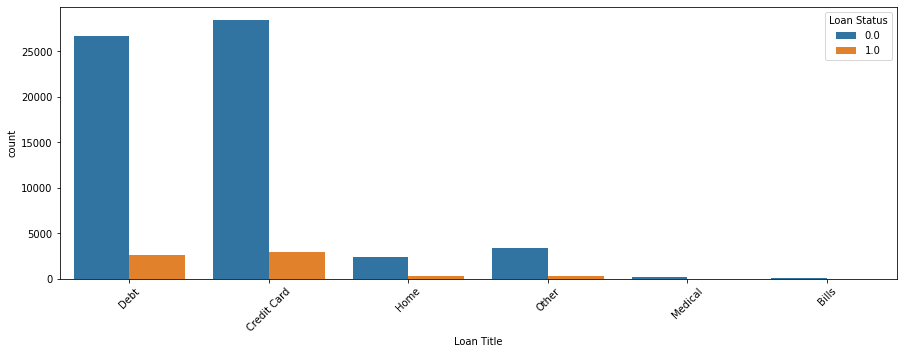

In [37]:
plt.figure(figsize=(15,5))
sns.countplot("Loan Title", hue="Loan Status", data=all_data)
plt.xticks(rotation=45)

In [38]:
all_data['Loan Title']= le.fit_transform(all_data['Loan Title'])

In [39]:
all_data.drop(columns=["Payment Plan", "Application Type"], inplace=True)

In [40]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96376 entries, 0 to 96375
Columns: 114 entries, Loan Amount to log_Funded_Amount_Investor
dtypes: float64(95), int64(19)
memory usage: 87.1 MB


# **Feature Selection**

removing all low-variance feature

In [41]:
loan_status = pd.DataFrame(all_data['Loan Status'])

In [42]:
loan_status

,Loan Status
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
96371,NaN
96372,NaN
96373,NaN
96374,NaN


In [43]:
vt = VarianceThreshold(0.005)

In [44]:
all_data_nums = all_data.drop(columns=['Grade', 'Home Ownership', 'Verification Status', 'Initial List Status', 'Batch Enrolled', 'Loan Status', 'Sub Grade', 'Loan Title'])

In [45]:
all_data_nums.shape

(96376, 106)

In [46]:
all_data_nums_normalized = all_data_nums / all_data_nums.mean()
all_data_nums_normalized.var()

Loan Amount                   0.250592
Funded Amount                 0.270255
Funded Amount Investor        0.179201
Term                          0.010671
Interest Rate                 0.090413
                                ...   
log_Loan_Amount               0.004154
log_Revolving_Balance         0.016980
log_Revolving_Utilities       0.026926
log_Funded_Amount             0.003308
log_Funded_Amount_Investor    0.002170
Length: 106, dtype: float64

In [47]:
_ = vt.fit(all_data_nums_normalized)

# Get the mask
mask = vt.get_support()

# Subset the DataFrame
all_data_nums_final = all_data_nums.loc[:, mask]
all_data_nums_final.shape

(96376, 40)

In [48]:
selected_cols = ['Grade', 'Home Ownership', 'Verification Status', 'Initial List Status', 'Batch Enrolled']
for i in all_data_nums_final.columns:
  selected_cols.append(i)
len(selected_cols)

45

In [49]:
all_data = all_data[selected_cols]
all_data.shape

(96376, 45)

In [ ]:
'''all_data = all_data / all_data.mean()'''

'all_data = all_data / all_data.mean()'

In [50]:
all_data['Loan Status'] = loan_status

# **Machine Learning**

### **Separate train and test data from the combined dataframe**

In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Create target variable
y = train['Loan Status']
# Create feature variable
X = train.drop(columns=['Loan Status'], axis=1)


test = test.drop(columns=['Loan Status'], axis=1) 
# Create training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("test shape: ", test.shape)

X shape:  (67463, 46)
y shape:  (67463,)
test shape:  (28913, 46)


##### Evaluation function

In [ ]:
#eval function 
def evaluate(ytest, ypred, y_predproba): 
  print("Acuracy", accuracy_score(ytest, ypred))
  print("_"*10)
  print("Recall", recall_score(ytest, ypred))
  print("_"*10)
  print("F1 Score", f1_score(ytest, ypred))
  print("_"*10)

  confusion = confusion_matrix(ytest, ypred)
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  confusion.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      confusion.flatten()/np.sum(confusion)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  matrix = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')
  matrix
  figsize=(10, 6)

  fpr, tpr, thresholds = roc_curve(ytest, y_predproba)
  auc = roc_auc_score(ytest, y_predproba)
  plt.figure(figsize=(8,5))

  # Plot the ROC curve
  plt.plot(fpr,tpr,label="AUC="+str(auc))

  # Add labels and diagonal line
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")

  plt.legend(loc=4)
  plt.plot([0, 1], [0, 1], "k--")
  plt.show()
  return

#### **Oversampling**

In [ ]:
'''#oversampling
print("Original Data: ", Counter(y))
os = RandomOverSampler(1, random_state=1)
X, y = os.fit_resample(X, y)
print("After Over Sampling: ", Counter(y))'''

'#oversampling\nprint("Original Data: ", Counter(y))\nos = RandomOverSampler(1, random_state=1)\nX, y = os.fit_resample(X, y)\nprint("After Over Sampling: ", Counter(y))'

#### **LightGBM with hyperparameters tuning** 

In [ ]:
def objective_lgbm(trial, X, y):
    param_grid = {
        "objective":"binary",
        "n_estimators": trial.suggest_categorical("n_estimators", [10, 20, 30, 40, 50, 60, 100, 120, 140, 160]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step = 0.05),
        "num_leaves": trial.suggest_int("num_leaves", 5, 30, step=5),
        "max_depth": trial.suggest_int("max_depth", 3, 12, step = 0.5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 500, step=50),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 12, step=0.5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 12, step=0.5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15, step = 3),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.05
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.05
        ),
    }

    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=123)

    cv_scores = np.empty(7)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)[:,1]
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective_lgbm(trial, X, y)
study.optimize(func, n_trials=25)

In [ ]:
print(f"\tBest value (binary_logloss): {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (binary_logloss): 0.30753
	Best params:
		n_estimators: 60
		learning_rate: 0.21000000000000002
		num_leaves: 30
		max_depth: 9
		min_data_in_leaf: 400
		lambda_l1: 5
		lambda_l2: 4
		min_gain_to_split: 3.0
		bagging_fraction: 0.65
		bagging_freq: 1
		feature_fraction: 0.45


In [ ]:
best_params = study.best_params 
best_params.update({'objective':'binary'})

In [ ]:
def lightgbm_hyp_fit(train, test, X, y):

  log_loss_scores = []
  kf = StratifiedKFold(n_splits = 10)
  y_preds = np.zeros(train.shape[0])
  test_preds = np.zeros(test.shape[0])
  evals_result = {}
  for count, (train_index, test_index) in enumerate(kf.split(X, y)):
      x_train,x_test = X.iloc[train_index], X.iloc[test_index]
      y_train,y_test = y.iloc[train_index], y.iloc[test_index]

      print(f"================================Fold {count+1}====================================")
      train_set = lgb.Dataset(x_train, y_train)
      test_set = lgb.Dataset(x_test, y_test)
      lgbfit=lgb.train(best_params, 
                train_set = train_set,
                valid_sets = [train_set, test_set], 
                early_stopping_rounds=30,
                evals_result=evals_result
                )
      
      y_pred = lgbfit.predict(x_test)
      y_preds[test_index] = y_pred 


      test_preds += lgbfit.predict(test)

      print('\nValidation log_loss:', log_loss(y_test, y_pred))
      log_loss_scores.append(log_loss(y_test, y_pred))
      
  print('mean log_loss_scores' ,np.mean(log_loss_scores))
  lgb.plot_metric(evals_result)

  '''feature_imp = pd.DataFrame(sorted(zip(lgbfit.feature_importance(),X.columns)), columns=['Value','Feature'])
  plt.figure(figsize=(20, 10))
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
  plt.tight_layout()
  plt.show()'''
  

  return y_preds ,test_preds/10

================================Fold 1====================================
[1]	training's binary_logloss: 0.307912	valid_1's binary_logloss: 0.308268
Training until validation scores don't improve for 30 rounds.
[2]	training's binary_logloss: 0.307602	valid_1's binary_logloss: 0.308209
[3]	training's binary_logloss: 0.307294	valid_1's binary_logloss: 0.30811
[4]	training's binary_logloss: 0.307178	valid_1's binary_logloss: 0.308064
[5]	training's binary_logloss: 0.306873	valid_1's binary_logloss: 0.307878
[6]	training's binary_logloss: 0.30655	valid_1's binary_logloss: 0.307742
[7]	training's binary_logloss: 0.306346	valid_1's binary_logloss: 0.307856
[8]	training's binary_logloss: 0.30614	valid_1's binary_logloss: 0.307762
[9]	training's binary_logloss: 0.305894	valid_1's binary_logloss: 0.307782
[10]	training's binary_logloss: 0.305803	valid_1's binary_logloss: 0.307814
[11]	training's binary_logloss: 0.305511	valid_1's binary_logloss: 0.307989
[12]	training's binary_logloss: 0.30534

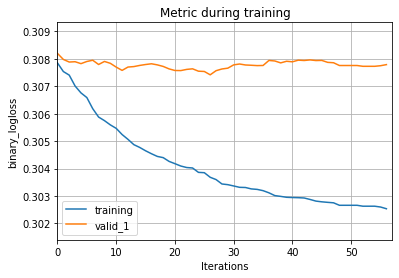

In [ ]:
y_preds_lgbm, test_preds_lgbm = lightgbm_hyp_fit(train, test, X, y)

#### **Catboost w/ hyperparameters tuning**

In [ ]:
def objective_catboost(trial, X, y):
  param_grid = {
      "loss_function":"Logloss",
      "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
      "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
      "depth": trial.suggest_int("depth", 1, 10, step = 0.5),
      "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
      "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
      "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20, step = 2),
      "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20,  step = 2),
      "od_type": "Iter"}
  
  #Conditional Hyper-Parameters
  if param_grid["bootstrap_type"] == "Bayesian":
    param_grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10, step = 0.05)
  elif param_grid["bootstrap_type"] == "Bernoulli":
    param_grid["subsample"] = trial.suggest_float("subsample", 0.1, 1)

  cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1234)

  cv_scores = np.empty(7)
  for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
      X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]

      model = CatBoostClassifier(**param_grid, eval_metric="Logloss", task_type="GPU", devices='0:1')
      model.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=300,
          verbose=50,
          use_best_model=True
      )
      preds = model.predict_proba(X_test)
      cv_scores[idx] = log_loss(y_test, preds)

  return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="Catboost Classifier")
func = lambda trial: objective_catboost(trial, X, y)
study.optimize(func, n_trials=5)

In [ ]:
best_params_cat = study.best_params 
print(f"\tBest value (Logloss): {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (Logloss): 0.30753
	Best params:
		learning_rate: 0.2506316955890798
		l2_leaf_reg: 0.01598350313098377
		depth: 1
		boosting_type: Plain
		bootstrap_type: Bernoulli
		min_data_in_leaf: 10
		one_hot_max_size: 4
		subsample: 0.29459012629514114


In [ ]:
def catboost_hyp_fit(train, test, X, y):

  log_loss_scores = []
  kf = StratifiedKFold(n_splits = 10)
  y_preds = np.zeros(train.shape[0])
  test_preds = np.zeros(test.shape[0])
  evals_result_ = {}

  for count, (train_index, test_index) in enumerate(kf.split(X, y)):
      x_train,x_test = X.iloc[train_index], X.iloc[test_index]
      y_train,y_test = y.iloc[train_index], y.iloc[test_index]

      print(f"================================Fold {count+1}====================================")
      '''catfit=cat.train(params = best_params_cat, 
                dtrain = cat.Pool(x_train, y_train),
                eval_set = cat.Pool(x_test, y_test), 
                early_stopping_rounds=300, 
                verbose = 50
                )'''
      catfit=CatBoostClassifier(**best_params_cat)
      catfit.fit(x_train, y_train, eval_set = cat.Pool(x_test, y_test), early_stopping_rounds=300)
      y_pred = catfit.predict_proba(x_test)[:,1]
      y_preds[test_index] = y_pred 

      test_preds += catfit.predict_proba(test)[:,1]

      print('\nValidation log_loss:', log_loss(y_test, y_pred))
      log_loss_scores.append(log_loss(y_test, y_pred))
  print('mean log_loss_scores' ,np.mean(log_loss_scores))

  '''feature_imp = pd.DataFrame(sorted(zip(catfit.get_feature_importance(), X.columns)), columns=['Value','Feature'])

  plt.figure(figsize=(20, 10))
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
  plt.tight_layout()
  plt.show()'''
  return y_preds ,test_preds/10

In [ ]:
y_preds_cat ,test_preds_cat = catboost_hyp_fit(train, test, X, y)

#### **XGBoost**

In [ ]:
def objective(trial: Trial,X,y) -> float:
    
    joblib.dump(study, 'study.pkl')

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
                'max_depth':trial.suggest_int('max_depth', 2, 25),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
            }

In [ ]:
def objective_xgboost(trial, X, y):

  param_grid = {
            "n_estimators" : trial.suggest_int('n_estimators', 10, 100, step = 10),
            'max_depth':trial.suggest_int('max_depth', 2, 25, step = 2),
            'reg_alpha':trial.suggest_int('reg_alpha', 0, 5, step = 0.5),
            'reg_lambda':trial.suggest_int('reg_lambda', 0, 5, step = 0.5),
            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5, step = 0.5),
            'gamma':trial.suggest_int('gamma', 0, 5, step = 0.5),
            'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
            'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
            'nthread' : -1,
            "tree_method": 'gpu_hist',
            }


  cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1234)

  cv_scores = np.empty(7)
  for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
      X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]

      model = XGBClassifier(**param_grid)
      model.fit(
          X_train,
          y_train,
          eval_set=[(X_test, y_test)],
          verbose=50,
          eval_metric="logloss"
      )
      preds = model.predict_proba(X_test, ntree_limit = model.get_booster().best_ntree_limit)[:,1] 
      cv_scores[idx] = log_loss(y_test, preds)

  return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="XGBoost Classifier")
func = lambda trial: objective_xgboost(trial, X, y)
study.optimize(func, n_trials=5)

In [ ]:
best_params_xgb = study.best_params 
print(f"\tBest value (Logloss): {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (Logloss): 0.32064
	Best params:
		n_estimators: 50
		max_depth: 14
		reg_alpha: 1
		reg_lambda: 2
		min_child_weight: 4
		gamma: 3
		learning_rate: 0.04291981770850239
		colsample_bytree: 0.78


In [ ]:
def xgboost_hyp_fit(train, test, X, y):

  log_loss_scores = []
  kf = StratifiedKFold(n_splits = 10)
  y_preds = np.zeros(train.shape[0])
  test_preds = np.zeros(test.shape[0])

  for count, (train_index, test_index) in enumerate(kf.split(X, y)):
      x_train,x_test = X.iloc[train_index], X.iloc[test_index]
      y_train,y_test = y.iloc[train_index], y.iloc[test_index]

      print(f"================================Fold {count+1}====================================")
      XGBfit=XGBClassifier(**best_params_xgb)
      XGBfit.fit(x_train, y_train, 
                 eval_set=[(x_test, y_test)],
                 early_stopping_rounds=200,
                 eval_metric="logloss")
      y_pred = XGBfit.predict_proba(x_test,ntree_limit = XGBfit.get_booster().best_ntree_limit)[:,1] 
      y_preds[test_index] = y_pred 

      test_preds += XGBfit.predict_proba(test,ntree_limit = XGBfit.get_booster().best_ntree_limit)[:,1] 

      print('\nValidation log_loss:', log_loss(y_test, y_pred))
      log_loss_scores.append(log_loss(y_test, y_pred))
  print('mean log_loss_scores' ,np.mean(log_loss_scores))

  return y_preds ,test_preds/10

In [ ]:
y_preds_xgb ,test_preds_xgb = xgboost_hyp_fit(train, test, X, y)

#### **Stacking**

In [ ]:
y_preds_stacked = np.column_stack((y_preds_lgbm, y_preds_cat, y_preds_xgb))
test_preds_stacked = np.column_stack((test_preds_lgbm, test_preds_cat, test_preds_xgb))
predictions = LinearRegression().fit(y_preds_stacked, target).predict(test_preds_stacked)

In [ ]:
stack_sub = ss.copy()
stack_sub['Loan Status'] = stack_sub 
stack_sub.to_csv("stack_sub.csv", index =False)